In [9]:
import pandas as pd
import numpy as np
import math as m
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy import stats
import seaborn as sns
import statsmodels.formula.api as sm
import statsmodels.stats.multicomp as multi
import sklearn
from sklearn import mixture
from sklearn import datasets
from sklearn import model_selection
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import StratifiedKFold


Functions are defined and explained for later use

In [10]:
#Group is extracted from the dataframe
colors = ['blue', 'purple', 'red']
def df_groupby_group_extract(df, col_to_extract, group_col, group_to_extract):
    idx = df.index[df[group_col] == group_to_extract]
    column_group = df[col_to_extract][idx]
    return column_group
#Iris csv data is imported as a dataframe
def get_iris_df():
    ds = sklearn.datasets.load_iris()
    df = pd.DataFrame(ds['data'], columns = ds['feature_names'])
    map_code_species = dict(zip(range(3), ds['target_names']))
    df['species'] = [map_code_species[c] for c in ds['target']]
    df.rename(columns={'sepal length (cm)': 'sepal_length',
                        'sepal width (cm)': 'sepal_width',
                        'petal length (cm)': 'petal_length',
                        'petal width (cm)': 'petal_width',}, inplace=True)
    return df
#Dataframe mean and variance    
def df_stats(df):
    df_stats = df.agg(['mean', 'var']) 
    return df_stats
#For each specific column determine the dataframe column mean and variance 
def df_stats_wrt_column(df, column):
    df_stats = df.groupby([column]).agg(['mean', 'var']) 
    return df_stats
#Determine the t value
def ttest_1samp_eq(x, u, s, n):
    t = (x - u)/(s/np.sqrt(n))
    return t
#Determine the sample mean vals and sizes
def ttest_1samp(sample, popmean):
    x = sample.mean()
    s = sample.std()
    n = sample.size
    return ttest_1samp_eq(x, popmean, s, n)
#Determine whether or not the dataframe is within the required range
def df_ttest_1samp(df, classes):
    class_names = df[classes].unique() #Get class names
    column_names = df.columns #Determine column names
    num_class = class_names.size #Get classes count
    num_columns = column_names.size - 1 #Useable columns count
    data = np.zeros([num_class, num_columns])  #Define zero array
    tstat_df = pd.DataFrame(data, index=class_names, columns=column_names[0:num_columns]) # Create tstat dataframe
    for i in range(num_class): #Work through classes
        for j in range(num_columns): #Work through columns
            u = df[column_names[j]].mean() #Determine population mean val
            sample = df_groupby_group_extract(df, column_names[j], classes, class_names[i]) # Extract sample
            tstat_df.loc[class_names[i], column_names[j]] = ttest_1samp(sample, u) 
    return tstat_df
#Determine dataframe p value
def df_pval_1samp(df, classes):
    class_names = df[classes].unique() #Get class names
    column_names = df.columns #Determine column names
    num_class = class_names.size #Get classes count
    num_columns = column_names.size - 1 #Useable columns count
    data = np.zeros([num_class, num_columns]) 
    #Define zero array
    pval_df = pd.DataFrame(data, index=class_names, columns=column_names[0:num_columns]) 
    #Define Tstats datafame
    for i in range(num_class): #Work through classes
        for j in range(num_columns): #Work through columns
            u = df[column_names[j]].mean() #Determine population mean val
            sample = df_groupby_group_extract(df, column_names[j], classes, class_names[i])
            pval_df.loc[class_names[i], column_names[j]] = stats.ttest_1samp(sample, u).pvalue #P value is calculated
    return pval_df
#Add gausian noise for classes
def add_noise_per_class(df):
    df_noise = df.copy() #Create duplicate dataframe
    class_names = df['species'].unique() #Get class names
    column_names = df_noise.columns #Determine column names
    num_class = class_names.size #Determine classes count
    num_columns = column_names.size - 1 #Useable columns count
    class_std = df_noise.groupby(['species']).std() #Calc dataframe's STD per class
    for i in range(num_class): #Work through classes
        for j in range(num_columns): #Work through columns
            std = class_std.at[class_names[i],column_names[j]] #Specific column of class STD value
            idx = df_noise.index[df_noise['species'] == class_names[i]] #Determine specific class column index
            noise = np.random.normal(0, std, size=None) #Calc noise 
            df_noise.loc[idx,column_names[j]] = df_noise[column_names[j]][idx] + noise 
            # Add noise to data
    return df_noise 
#Per Element 
def add_noise_per_element(df):
    df_noise = df.copy() #Create duplicate dataframe
    class_names = df['species'].unique() # Get class names
    column_names = df_noise.columns #Determine column names
    num_class = class_names.size # Determine number of classes
    num_columns = column_names.size - 1 # Determine number of usable columns
    class_std = df_noise.groupby(['species']).std() #Calc dataframe's STD per class
    for i in range(num_class): #Work through classes
        for j in range(num_columns): #Work through columns
            std = class_std.at[class_names[i],column_names[j]] #Specific column of class STD value
            idx = df_noise.index[df_noise['species'] == class_names[i]] #Determine specific class column index
            for k in range(idx.size): # Iterate through elements
                noise = np.random.normal(0, std, size=None) #Calc noise 
                df_noise.loc[idx[k],column_names[j]] = df_noise[column_names[j]][idx[k]] + noise # Add noise to data
        return df_noise
#ANOVA analysis
def element_anova(df,col_no):
    column_name = df.columns
    d = column_name[col_no] + '~ C(species)'
    subset = sm.ols(formula=d, data=df)
    subset_data = subset.fit().summary()
    subset_data_F = subset_data.tables[0].data[2][3]
    subset_data_P = subset_data.tables[0].data[3][3]
    F = subset_data_F
    P = subset_data_P
    return [F,P]
#Gausian clustering
def make_ellipses(gmm, ax):
    for n, color in enumerate(colors):
        if gmm.covariance_type == 'full':
            covariances = gmm.covariances_[n][:2, :2]
        elif gmm.covariance_type == 'tied':
            covariances = gmm.covariances_[:2, :2]
        elif gmm.covariance_type == 'diag':
            covariances = np.diag(gmm.covariances_[n][:2])
        elif gmm.covariance_type == 'spherical':
            covariances = np.eye(gmm.means_.shape[1]) * gmm.covariances_[n]
        v, w = np.linalg.eigh(covariances)
        u = w[0] / np.linalg.norm(w[0])
        angle = np.arctan2(u[1], u[0])
        angle = 180 * angle / np.pi                                                         #Convert angle to degrees
        v = 2. * np.sqrt(2.) * np.sqrt(v)
        ell = mpl.patches.Ellipse(gmm.means_[n, :2], v[0], v[1],180 + angle, color=color)
        ell.set_clip_box(ax.bbox)
        ell.set_alpha(0.5)
        ax.add_artist(ell)
        ax.set_aspect('equal', 'datalim')



1.	Download the Fisher Iris data from efundi. The first 4 columns contain the values of 4 features to be used as inputs (petal lengths and widths) and column 5 contains the class labels (species of iris).  Calculate the average and variance of each feature for the total population and for each class.  Write a function for this purpose that can be re-used.

In [11]:
df = get_iris_df() #Data set is imported
df.rename(columns={'sepal length (cm)': 'sepal_length',
                    'sepal width (cm)': 'sepal_width',
                    'petal length (cm)': 'petal_length',
                    'petal width (cm)': 'petal_width',}, inplace=True)
df_stats_original = df_stats(df) #Dataframe mean and varience
original_species_stats = df_stats_wrt_column(df,'species') #Species based varience and mean vals determined
original_species_stats.head()


C:\Users\Willie\AppData\Local\Temp\ipykernel_12012\3431300259.py:20: FutureWarning: ['species'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  df_stats = df.agg(['mean', 'var'])


sepal_length           sepal_width           petal_length  \
                   mean       var        mean       var         mean   
species                                                                
setosa            5.006  0.124249       3.428  0.143690        1.462   
versicolor        5.936  0.266433       2.770  0.098469        4.260   
virginica         6.588  0.404343       2.974  0.104004        5.552   

                     petal_width            
                 var        mean       var  
species                                     
setosa      0.030159       0.246  0.011106  
versicolor  0.220816       1.326  0.039106  
virginica   0.304588       2.026  0.075433

2.	Generate an additional noisy data set by adding to each original observation a value from a Gaussian distribution with zero average value and standard deviation equal to the standard deviation of the class to which that observation belongs. Calculate the average and variance of each feature for the total noisy population and for each noisy class, using the function created in question 1.  Explain the difference observed between the statistics of the original and noisy population and classes. (6) 


In [12]:
df_added_noise_class = add_noise_per_class(df) #Noise added to dataframe per class 
df_added_noise_element = add_noise_per_element(df) #Noise added to dataframe per element
df_stats_noise_class = df_stats(df_added_noise_class) #Mean and varience of dataframe per class
df_stats_noise_element = df_stats(df_added_noise_element) #Mean and varience of dataframe per element
original_species_stats.head() #Mean and varience of database based on spec
species_stats_noise_element_df = df_stats_wrt_column(df_added_noise_element,'species')
species_stats_noise_element_df.head()



C:\Users\Willie\AppData\Local\Temp\ipykernel_12012\3431300259.py:20: FutureWarning: ['species'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  df_stats = df.agg(['mean', 'var'])
C:\Users\Willie\AppData\Local\Temp\ipykernel_12012\3431300259.py:20: FutureWarning: ['species'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  df_stats = df.agg(['mean', 'var'])


sepal_length           sepal_width           petal_length  \
                   mean       var        mean       var         mean   
species                                                                
setosa          4.99133  0.235333    3.480419  0.272003     1.444651   
versicolor      5.93600  0.266433    2.770000  0.098469     4.260000   
virginica       6.58800  0.404343    2.974000  0.104004     5.552000   

                     petal_width            
                 var        mean       var  
species                                     
setosa      0.045985    0.250582  0.022292  
versicolor  0.220816    1.326000  0.039106  
virginica   0.304588    2.026000  0.075433

3.	Calculate the t-statistics for each feature of each class and determine how significantly the classes differ from the population.  Repeat this for the original and noisy classes, using the same function in each case.  Explain the difference observed between the t-statistics of the original and noisy classes. (8)

In [13]:
df_tstats = df_ttest_1samp(df, 'species') 
df_pval = df_pval_1samp(df, 'species')
df_tstats.head()
df_noisy_tstats = df_ttest_1samp(df_added_noise_element, 'species')
df_noisy_tstats.head()

,sepal_length,sepal_width,petal_length,petal_width
setosa,-12.347664,5.499328,-76.090543,-45.004875
versicolor,1.336435,-6.868447,7.640952,4.474624
virginica,8.335172,-2.210285,23.059447,21.243820


4.	Perform a one-way analysis of variation (ANOVA1) analysis for both the original and noisy data sets to determine if the respective classes are significantly different from the population; in the process you must generate F-statistics and p-values for each feature. Based on the results of the ANOVA analysis, select the two features that provide the best distinction between the classes. Generate two scatterplots, first of the two most prominent features, and then of the two least prominent features. Comment on their abilities to separate the classes. (8)

Text(0.5, 1.0, 'Least prominent features')

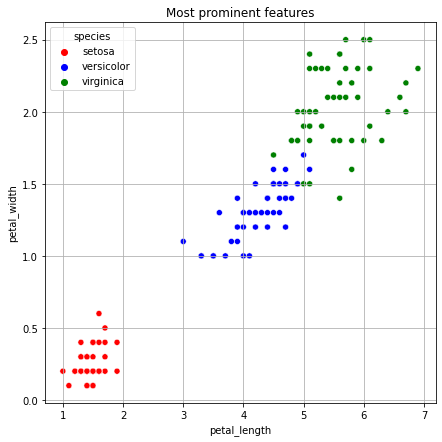

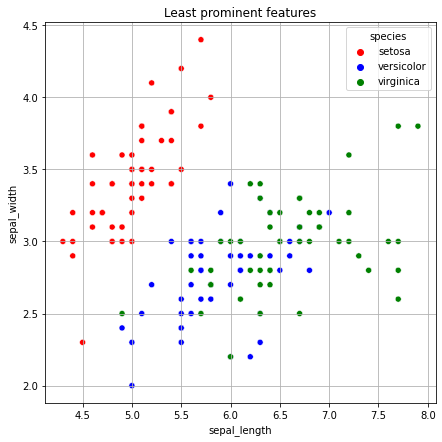

In [14]:
Anova_data = np.transpose([element_anova(df,0),element_anova(df,1),element_anova(df,2),element_anova(df,3)])
df_Anova = pd.DataFrame(Anova_data, columns=df.columns[0:4], index=['F', 'P'])
df_Anova.head()
Noisy_Anova_data = np.transpose([element_anova(df_added_noise_element,0),element_anova(df_added_noise_element,1),element_anova(df_added_noise_element,2),element_anova(df_added_noise_element,3)])
df_Noisy_Anova = pd.DataFrame(Noisy_Anova_data, columns=df.columns[0:4], index=['F', 'P'])
df_Noisy_Anova.head() 
plt.figure(figsize=(7,7))
sns.scatterplot(data=df,
                x="petal_length",
                y="petal_width",
                hue="species",
                palette=["red","blue","green"])
plt.grid()
plt.title('Most prominent features')
plt.figure(figsize=(7,7))
sns.scatterplot(data=df,
                x="sepal_length",
                y="sepal_width",
                hue="species",
                palette=["red","blue","green"])
plt.grid()
plt.title('Least prominent features')


5.	Repeat the following analyses for the original and noisy classes, using the same function in each case:  
a)	Apply principal component analysis to the 4 features.  
b)	Determine what fraction of total variance in the set is represented by each principal component. 
c)	Generate two scatterplots, first of the two most prominent principal components, and then of the two least prominent principal components. Comment on their abilities to separate the classes.  
d)	Explain the differences that are observed for the original and noisy data sets.	(8)


,PC 1,PC 2,PC 3,PC 4
Original,90.951553,5.885041,2.452747,0.710659
Standardized,72.701815,21.965540,4.591182,0.741463


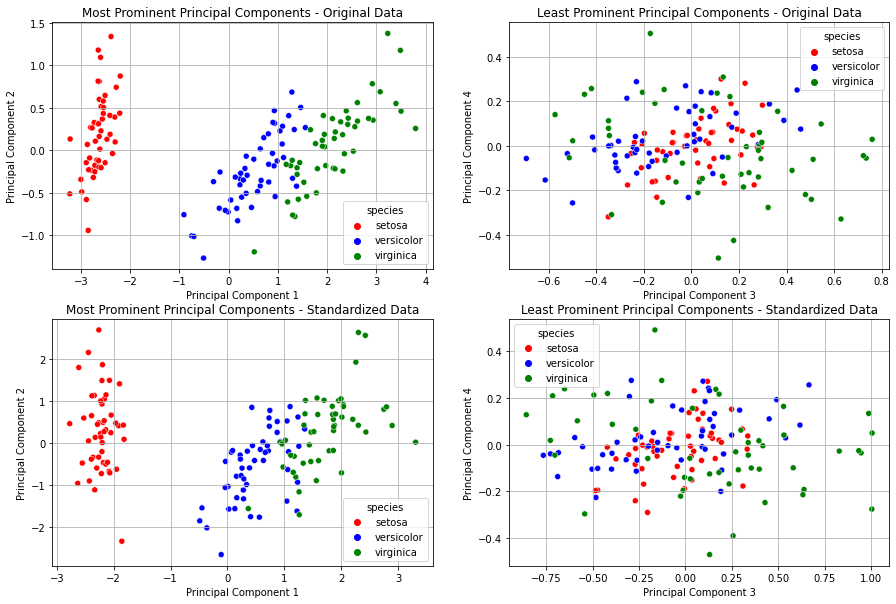

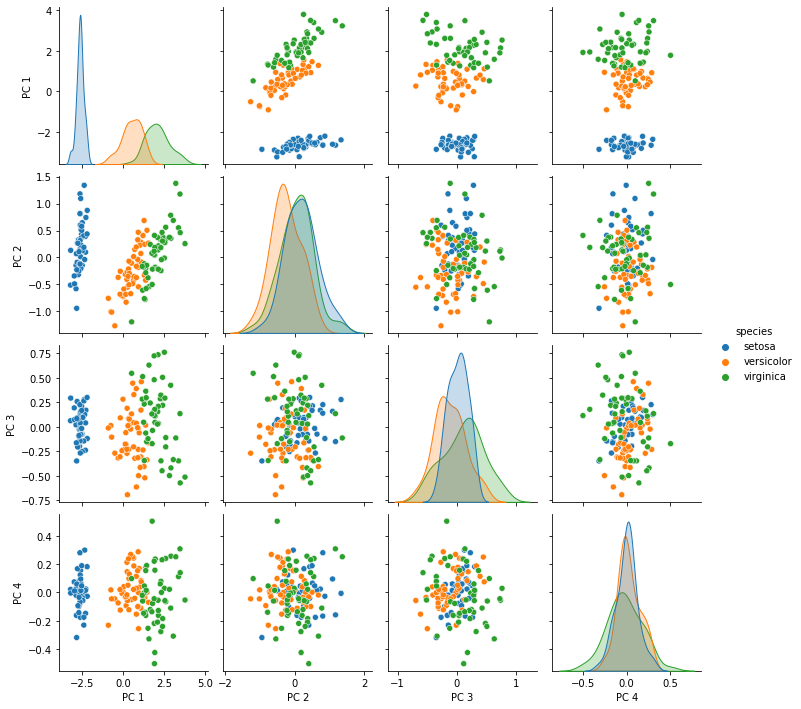

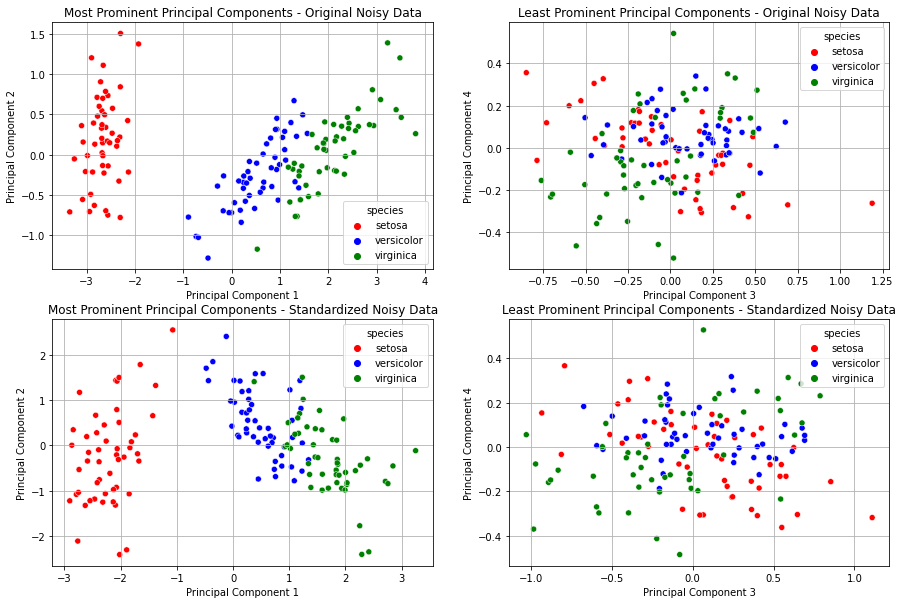

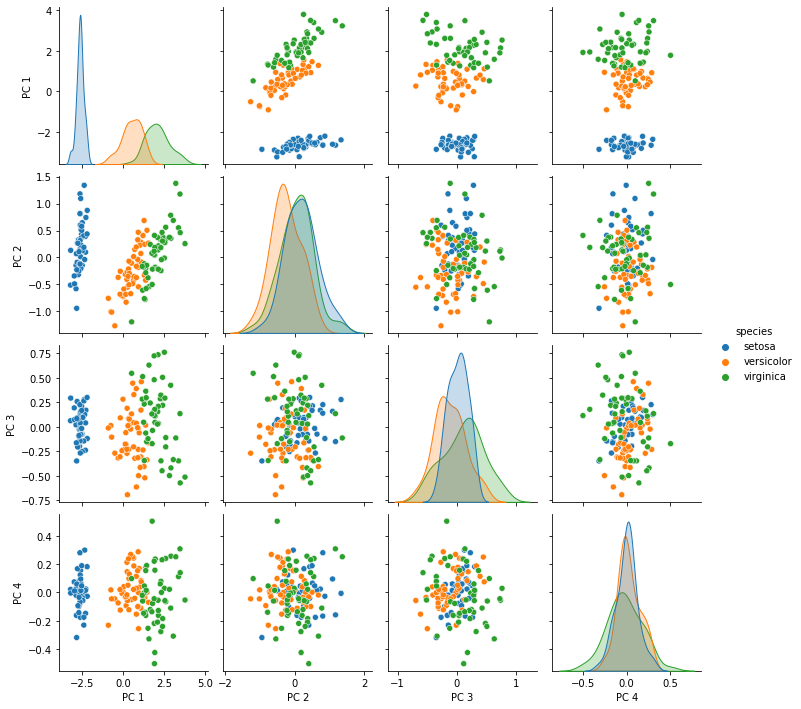

In [15]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
#Dataset is standardized
original_data = df[df.columns[0:4]]
standardized_data = StandardScaler().fit_transform(df[df.columns[0:4]])
#Principle component analysis
pca_org = PCA(n_components=4) #Count of principal components to be kept 
principalComponents_org = pca_org.fit_transform(original_data) # Calc Principal component values using SVD
principal_org_Df = pd.DataFrame(data = principalComponents_org, columns = ['PC 1', 'PC 2', 'PC 3', 'PC 4'])
PCA_org_df = pd.concat([principal_org_Df, df[['species']]], axis = 1)
#Standardized Data
pca_stand = PCA(n_components=4) # 
#Count of principal components to be kept 
principalComponents_stand = pca_stand.fit_transform(standardized_data) # 
#Calc Principal component values using SVD
principal_stand_Df = pd.DataFrame(data = principalComponents_stand, columns = ['PC 1', 'PC 2', 'PC 3', 'PC 4'])
PCA_stand_df = pd.concat([principal_stand_Df, df[['species']]], axis = 1)
#Plot Principal Components
fig, axes = plt.subplots(2,2, figsize=(15,10))
#Determine ost prominent principal components 
sns.scatterplot(ax=axes[0,0],
                data=PCA_org_df,
                x="PC 1",
                y="PC 2",
                hue="species",
                palette=["red","blue","green"])
axes[0,0].set_title('Most Prominent Principal Components - Original Data')
axes[0,0].set_xlabel('Principal Component 1')
axes[0,0].set_ylabel('Principal Component 2')
axes[0,0].grid()
#Determine least prominent principal components 
sns.scatterplot(ax=axes[0,1],
                data=PCA_org_df,
                x="PC 3",
                y="PC 4",
                hue="species",
                palette=["red","blue","green"])
axes[0,1].set_title('Least Prominent Principal Components - Original Data')
axes[0,1].set_xlabel('Principal Component 3')
axes[0,1].set_ylabel('Principal Component 4')
axes[0,1].grid()
#Determine most prominent principal components [Standardized Data]
sns.scatterplot(ax=axes[1,0],
                data=PCA_stand_df,
                x="PC 1",
                y="PC 2",
                hue="species",
                palette=["red","blue","green"])
axes[1,0].set_title('Most Prominent Principal Components - Standardized Data')
axes[1,0].set_xlabel('Principal Component 1')
axes[1,0].set_ylabel('Principal Component 2')
axes[1,0].grid()
#Determine least prominent principal components [Standardized Data]
sns.scatterplot(ax=axes[1,1],
                data=PCA_stand_df,
                x="PC 3",
                y="PC 4",
                hue="species",
                palette=["red","blue","green"])
axes[1,1].set_title('Least Prominent Principal Components - Standardized Data')
axes[1,1].set_xlabel('Principal Component 3')
axes[1,1].set_ylabel('Principal Component 4')
axes[1,1].grid()
#Plot Principal Components
sns.pairplot(PCA_org_df, hue='species')
#Dataset is standardized
original_data_noisy = df_added_noise_element[df_added_noise_element.columns[0:4]]
standardized_data_noisy = StandardScaler().fit_transform(df_added_noise_element[df_added_noise_element.columns[0:4]])
#Principle component analysis
pca_org_noisy = PCA(n_components=4) 
# Count of principal components to be kept 
principalComponents_org_noisy = pca_org_noisy.fit_transform(original_data_noisy) 
 # Calc Principal component values using SVD
principal_org_noisy_df = pd.DataFrame(data = principalComponents_org_noisy, columns = ['PC 1', 'PC 2', 'PC 3', 'PC 4'])
PCA_org_noisy_df = pd.concat([principal_org_noisy_df, df_added_noise_element[['species']]], axis = 1)
#Standardized Data
pca_stand_noisy = PCA(n_components=4) 
#Count of principal components to be kept 
principalComponents_stand_noisy = pca_stand_noisy.fit_transform(standardized_data_noisy) #Calc Principal component values using SVD
principal_stand_noisy_df = pd.DataFrame(data = principalComponents_stand_noisy, 
columns = ['PC 1', 'PC 2', 'PC 3', 'PC 4'])
PCA_stand_noisy_df = pd.concat([principal_stand_noisy_df, 
df_added_noise_element[['species']]], axis = 1)
#Plot Principal Components
fig, axes = plt.subplots(2,2, figsize=(15,10))
#Determine most prominent principal components [Original Noisy Data]
sns.scatterplot(ax=axes[0,0],
                data=PCA_org_noisy_df,
                x="PC 1",
                y="PC 2",
                hue="species",
                palette=["red","blue","green"])
axes[0,0].set_title('Most Prominent Principal Components - Original Noisy Data')
axes[0,0].set_xlabel('Principal Component 1')
axes[0,0].set_ylabel('Principal Component 2')
axes[0,0].grid()
#Determine least prominent principal components [Original Noisy Data]
sns.scatterplot(ax=axes[0,1],
                data=PCA_org_noisy_df,
                x="PC 3",
                y="PC 4",
                hue="species",
                palette=["red","blue","green"])
axes[0,1].set_title('Least Prominent Principal Components - Original Noisy Data')
axes[0,1].set_xlabel('Principal Component 3')
axes[0,1].set_ylabel('Principal Component 4')
axes[0,1].grid()
#Determine most prominent principal components [Standardized Noisy Data]
sns.scatterplot(ax=axes[1,0],
                data=PCA_stand_noisy_df,
                x="PC 1",
                y="PC 2",
                hue="species",
                palette=["red","blue","green"])
axes[1,0].set_title('Most Prominent Principal Components - Standardized Noisy Data')
axes[1,0].set_xlabel('Principal Component 1')
axes[1,0].set_ylabel('Principal Component 2')
axes[1,0].grid()
#Determine Least prominent principal components [Standardized Noisy Data]
sns.scatterplot(ax=axes[1,1],  
                data=PCA_stand_noisy_df,
                x="PC 3",
                y="PC 4",
                hue="species",
                palette=["red","blue","green"])
axes[1,1].set_title('Least Prominent Principal Components - Standardized Noisy Data')
axes[1,1].set_xlabel('Principal Component 3')
axes[1,1].set_ylabel('Principal Component 4')
axes[1,1].grid()
#Plot Principal Components
sns.pairplot(PCA_org_df, hue='species')
#Variance ratios Original Dataset
data = [pca_org.explained_variance_ratio_*100,pca_stand.explained_variance_ratio_*100]
PCA_Retained_df = pd.DataFrame(data, columns=['PC 1','PC 2','PC 3','PC 4'], 
index=['Original','Standardized'])
PCA_Retained_df.head()
#Variance ratios of Noisy Dataset
data = [pca_org_noisy.explained_variance_ratio_*100,pca_stand_noisy.explained_variance_ratio_*100]
PCA_Retained_noisy_df = pd.DataFrame(data, columns=['PC 1','PC 2','PC 3','PC 4'], index=['Original','Standardized'])
PCA_Retained_noisy_df.head() 